In [2]:
# Memory Allocation for using GPU 
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import numpy as np
import os


1 Physical GPUs, 1 Logical GPUs


## Load Dataset

In [26]:
# Project Path 
BASE_PATH = os.path.abspath(".")
DATA_PATH = os.path.abspath("..\\..\\00_MLDL\\00_BreadBrother\\07_Corona_Prediction")

# Confimation, recovery and death data sets by region worldwide
URL = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"


data = pd.read_csv(URL, error_bad_lines=False) # 오류나는 데이터 생략
#data1 = pd.read_csv(URL, error_bad_lines=True)

data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.93911,67.709953,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.93911,67.709953,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.93911,67.709953,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.93911,67.709953,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.93911,67.709953,0.0,0.0,0.0


## Pre-process

In [70]:
# Korea's confirmed case

# Row processing
df_korea = data[data["Country/Region"]=="Korea, South"] # Korea인 Row만 가져오기

# Column processing
df_korea = np.column_stack([df_korea.Date, df_korea.Confirmed]) # 필요한 Column만 추출

# change type to DataFrame
df_korea2 = pd.DataFrame(df_korea, columns=["Date", "Confirmed"])

df_korea = pd.DataFrame(df_korea)
df_korea = df_korea.reset_index().rename(columns={0:"Date", 1:"Confirmed"}) # index column 생성
df_korea = df_korea.drop("index", axis=1)

print(df_korea.describe())
print(df_korea2.describe())
print(df_korea.tail())


Date  Confirmed
count          210      210.0
unique         210      197.0
top     2020-08-14       28.0
freq             1        5.0
              Date  Confirmed
count          210      210.0
unique         210      197.0
top     2020-08-14       28.0
freq             1        5.0
           Date Confirmed
205  2020-08-14     15039
206  2020-08-15     15318
207  2020-08-16     15515
208  2020-08-17     15761
209  2020-08-18     16058


## Plot

In [71]:
# Plot Korea's COVID-19 confirmed cases

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = df_korea.Date,
        y = df_korea.Confirmed,
        name = "Confirmed cases in Korea"
    )
)

fig

## Facebook Prophet Pre-processing

In [73]:
# Make dataframe for Facebook Prophet prediction mode
df_prophet = df_korea.rename(
    columns={
        "Date": "ds",
        "Confirmed": "y"
    }
)

df_prophet.tail()

,ds,y
205,2020-08-14,15039
206,2020-08-15,15318
207,2020-08-16,15515
208,2020-08-17,15761
209,2020-08-18,16058


## Create Model
### Add change points to make more flexible
- https://facebook.github.io/prophet/docs/trend_changepoints.html

In [105]:
# Make Prophet model including daily seasonality
m = Prophet(
    changepoint_prior_scale=0.5, # Increasing it will make the trend more flexible
    changepoint_range=0.98, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode="additive"
)

history = m.fit(df_prophet)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

# conda install -c plotly plotly-orca
fig.write_image(".\\forcast_line.png")

## Plot change points

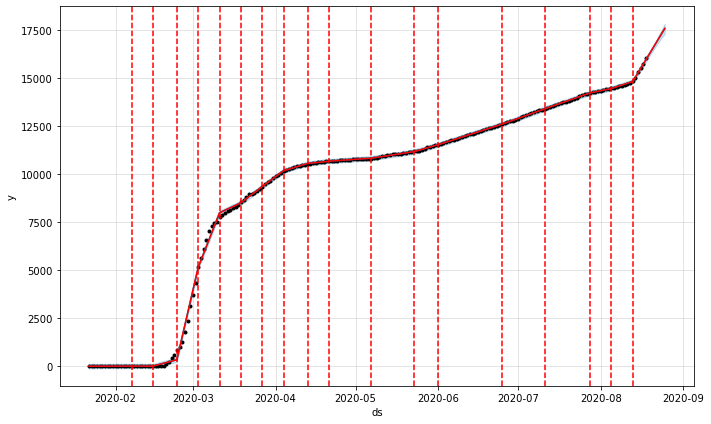

In [107]:
# Display changepoints as red dotted line on the plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
fig.savefig("changepoints.png")